## Missing Fingers

In [1]:
import pandas as pd
import numpy as np
import pyro 

from typing import Dict, List
from scipy.stats import entropy
from scipy.stats import beta
import pyro.distributions as dist
import torch

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import warnings 

Importing the functions:

In [2]:
def normalize_sample(sample: torch.Tensor, k: int = 1000) -> torch.Tensor:
    ''' 
    `sample` is supposed to be a sample of values, returns probabilites across k bins.
    '''

    hist = torch.histc(sample, bins=k)
    return hist / hist.sum()



def weight(posterior: torch.Tensor, base=2.) -> float:
    '''
    Calculates the weight of the posterior distribution.
    The weight is defined as 1 - H(posterior) / H(uniform)
    where H is the entropy of the distribution.
        param: posterior: torch.Tensor - tensor of probabilities (not samples). 
    '''
    
    if not isinstance(base, torch.Tensor):  # Check if base is not a tensor
        base = torch.tensor(base) 

    initial_length = posterior.shape[-1]
    posterior = posterior[~torch.isnan(posterior)]
    removed_length = initial_length - posterior.shape[-1]

    if initial_length != posterior.shape[-1]:#raise warning
        warnings.warn(f"Removed {removed_length} nan values from posterior")

    if posterior.numel() == 0:
        return float('nan')

    grid_length = posterior.shape[-1]
    x = torch.linspace(0, 1, grid_length)

    uniform = dist.Beta(1, 1).log_prob(x).exp()
    uniform = uniform/uniform.sum()

    #uniform = normalize_sample(uniform, k = uniform.shape[-1])

    assert torch.allclose(uniform.sum(), torch.tensor(1.)), f"Sum of uniform distribution is {uniform.sum()}"
    assert torch.allclose(posterior.sum(), torch.tensor(1.)), f"Sum of posterior distribution is {posterior.sum()}"

    entropy_uniform = -torch.sum(uniform * torch.log(uniform) /torch.log(base))

    entropy_posterior = -torch.sum(posterior * torch.log(posterior) / torch.log(base))

    return 1 - entropy_posterior.item() / entropy_uniform.item()

def expected_weight(probs_of_evidence: torch.Tensor, outcome_prior: torch.Tensor,
                    posteriors: List[torch.Tensor],  base=2) -> torch.Tensor:    
    """
    Calculate the expected weight change given a prior distribution, 
    posterior distributions, and the probabilities of evidence.

    Args:
    probs_of_evidence (torch.Tensor): A tensor of probabilities representing the likelihood of the evidence.
    outcome_prior (torch.Tensor): A tensor representing the prior distribution of outcomes.
    posteriors (List[torch.Tensor]): A list of tensors representing the posterior distributions.
    base (int): The base for calculating the weight (default is 2).

    """
    
    weight_prior = weight(outcome_prior, base=base) 

    posterior_weights = torch.tensor([weight(posterior, base=base) for posterior in posteriors])

    print(posterior_weights)
    weight_changes = posterior_weights - weight_prior

    weighted_weight_changes = weight_changes * probs_of_evidence 
    
    assert probs_of_evidence.shape == weighted_weight_changes.shape, 'shape mismatch'

    expected_weight = weighted_weight_changes.sum()

    return {"expected_weight": expected_weight, "weight_prior": weight_prior, 
            "posterior_weights": posterior_weights, 
            "weight_changes": weight_changes, 
            "weighted_weight_changes": weighted_weight_changes}    

Building Core model:

In [24]:
pyro.set_rng_seed(42)

def swedish_fingers_guilt_model(
        pr_identity: float = 0.01,               # Prior probability that the suspect is guilty
        rmp_fingers_sweden = 2 / 20000,          # RMP for Sweden
        pr_isis_if_not_guilty = 300 /10.6e6,                               
        pr_fingers_match_if_isis = 2 / 5000,     # RMP for ISIS memebers
        num_particles = 3e5                     
    ):
    
    with pyro.plate("particles", size=num_particles):
   
        guilty = pyro.sample("guilty", dist.Bernoulli(pr_identity))

        isis = pyro.sample("isis", dist.Bernoulli(
                                        guilty * 1 + (1 - guilty) * pr_isis_if_not_guilty
                                        )
                            )


        fingers_match_rmp = pyro.sample("fingers_match_not_isis", 
                                             # if guilty then 1
                                             # if not guilty then sample with probability rmp
                                                dist.Bernoulli(guilty * 1 + (1 - guilty) * (rmp_fingers_sweden)
                                                               )
                                            )
        

        fingers_match_isis = pyro.sample("fingers_match_isis", 
                                         # if guilty then 1
                                         # if not guilty then sample with probability pr_fingers_match_if_isis
                                            dist.Bernoulli(guilty * 1 + (1 - guilty) * ((pr_fingers_match_if_isis) * isis +
                                                              (1 - isis) * (rmp_fingers_sweden)
                                                                    )
                                                                )
                                                            ) 
        


    # Mask 1: fingers match
    evidence_mask_fingers_rmp = (fingers_match_rmp).bool()
    guilty_masked_fingers_rmp = pyro.deterministic(
        "guilty_masked_fingers_rmp",
        torch.where(evidence_mask_fingers_rmp, guilty, torch.tensor(float("nan")))            
        )

    
    posterior_guilty_fingers_rmp = pyro.deterministic(
        "posterior_guilty_fingers_rmp", torch.nanmean(guilty_masked_fingers_rmp, axis=0))
    

    # Mask 2: fingers match, isis
    evidence_mask_fingers_isis = (fingers_match_isis * isis).bool()
    guilty_masked_fingers_isis = pyro.deterministic(
        "guilty_masked_fingers_isis",
        torch.where(evidence_mask_fingers_isis, guilty, torch.tensor(float("nan")))            
        )
    
    posterior_guilty_fingers_isis = pyro.deterministic(
        "posterior_guilty_fingers_isis", torch.nanmean(guilty_masked_fingers_isis, axis=0))

        
        
    

    return {"guilty": guilty, "isis": isis, 'fingers_match_rmp': fingers_match_rmp, 
            'fingers_match_isis': fingers_match_isis,
            "posterior_guilty_fingers_rmp": posterior_guilty_fingers_rmp, 
            "posterior_guilty_fingers_isis": posterior_guilty_fingers_isis}
     

#set pyro random seed
pyro.set_rng_seed(422323)
swedish_fingers_guilt_model()

{'guilty': tensor([0., 0., 0.,  ..., 1., 0., 0.]),
 'isis': tensor([0., 0., 0.,  ..., 1., 0., 0.]),
 'fingers_match_rmp': tensor([0., 0., 0.,  ..., 1., 0., 0.]),
 'fingers_match_isis': tensor([0., 0., 0.,  ..., 1., 0., 0.]),
 'posterior_guilty_fingers_rmp': tensor(0.9871),
 'posterior_guilty_fingers_isis': tensor(1.)}

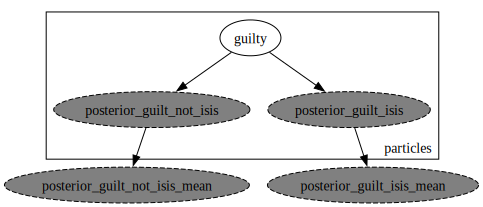

In [19]:
pyro.render_model(swedish_fingers_guilt_model, render_deterministic = True)


In [25]:
# extracting the posterior probabilities

with pyro.poutine.trace() as tr:
   pyro.set_rng_seed(42)
   swedish_fingers_guilt_model(num_particles=1e6)

for key in tr.trace.nodes.keys():
        if key.startswith("posterior"):
                print(key, tr.trace.nodes[key]['value'])
                


posterior_guilt_not_isis tensor([1.0000e-04, 1.0000e-04, 1.0000e-04,  ..., 1.0000e-04, 1.0000e-04,
        1.0000e-04])
posterior_guilt_isis tensor([0.0004, 0.0004, 0.0004,  ..., 0.0004, 0.0004, 0.0004])
posterior_guilt_not_isis_mean tensor(0.0102)
posterior_guilt_isis_mean tensor(0.0105)


In [53]:

posterior_guilt_not_isis_mean = torch.tensor([
    1 - tr.trace.nodes['posterior_guilt_not_isis_mean']['value'], 
    tr.trace.nodes['posterior_guilt_not_isis_mean']['value'],      
])

posterior_guilt_isis_mean = torch.tensor([
    1 - tr.trace.nodes['posterior_guilt_isis_mean']['value'],  
    tr.trace.nodes['posterior_guilt_isis_mean']['value'],     
])

print('posterior_guilt_not_isis_mean', posterior_guilt_not_isis_mean)
print('posterior_guilt_isis_mean', posterior_guilt_isis_mean)


pr_identity = 0.01              
pr_fingers_match_if_not_isis = 2 / 20000 
pr_fingers_match_if_isis = 2 / 5000


prior_guilt = torch.tensor([1 - pr_identity, pr_identity])  


probs_of_evidence = torch.tensor([
    pr_fingers_match_if_not_isis,  
    pr_fingers_match_if_isis         
])
print(probs_of_evidence)


posterior_guilt_not_isis_mean tensor([0.9898, 0.0102])
posterior_guilt_isis_mean tensor([0.9895, 0.0105])
tensor([1.0000e-04, 4.0000e-04])


In [54]:
expected_weights = expected_weight(
    probs_of_evidence, prior_guilt, 
    [posterior_guilt_not_isis_mean, posterior_guilt_isis_mean]
)

print("Expected Weights:", expected_weights)

tensor([0.9179, 0.9160])
Expected Weights: {'expected_weight': tensor(-1.4350e-06), 'weight_prior': 0.9192068800330162, 'posterior_weights': tensor([0.9179, 0.9160]), 'weight_changes': tensor([-0.0013, -0.0033]), 'weighted_weight_changes': tensor([-1.3228e-07, -1.3027e-06])}
